In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.utils import class_weight

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.utils import class_weight
from math import sqrt

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.utils import class_weight
from math import sqrt

In [ ]:
tf.random.set_seed(42)

In [ ]:
############################
##### Define Functions #####
############################
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
########################
##### Load Dataset #####
########################

df = pd.read_csv("final_data.csv", index_col=0)
# df.head()
# df.isnull().sum()

In [ ]:
#############################################
##### Feature selection and engineering #####
#############################################

X_numeric_cols = ['telecommuting', 'has_company_logo', 'has_questions', 'location_has_non_latin',
                  'description_has_non_latin', 'requirements_has_non_latin', 'has_requirements',
                  'has_location', 'has_location_details']
X_text_cols = ['title', 'description_and_requirements']
y_col = ['fraudulent']

df2 = df[X_numeric_cols + X_text_cols + y_col].dropna()

df2["combined_text"] = df2["title"] + " " + df2["description_and_requirements"]

X_numeric = df2[X_numeric_cols]
X_text = df2["combined_text"]
y = df2[y_col].values.ravel()  # Convert to 1D array


In [ ]:
# Split the dataset
X_numeric_train, X_numeric_test, X_text_train, X_text_test, y_train, y_test = train_test_split(
    X_numeric, X_text, y, test_size=0.2, random_state=42
)

# Convert text to TF-IDF features so that the neural network can process them
tfidf = TfidfVectorizer(max_features=500, stop_words='english')
X_text_train_tfidf = tfidf.fit_transform(X_text_train)
X_text_test_tfidf = tfidf.transform(X_text_test)

# Combine numeric and text features
X_train_processed = np.hstack([X_numeric_train.values, X_text_train_tfidf.toarray()])
X_test_processed = np.hstack([X_numeric_test.values, X_text_test_tfidf.toarray()])

print(f"Training shape: {X_train_processed.shape}")
print(f"Test shape: {X_test_processed.shape}")


Training shape: (14667, 509)
Test shape: (3667, 509)


In [ ]:
def build_model(layer_sizes, input_dim, learning_rate):
    
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    
    for size in layer_sizes:
        model.add(layers.Dense(size, activation='relu'))
    
    model.add(layers.Dense(1, activation='sigmoid'))  # outputs log-likelihood
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights = [weights[0] / sqrt(2), weights[1] * sqrt(2)]
class_weights = dict(enumerate(weights))
class_weights

{0: np.float64(0.38117962215756734), 1: np.float64(9.756477102223043)}

In [ ]:
trained_models = {}

# different architectures to compare
architectures = {
    "Shallow": [32],
    "Medium": [64, 32],
    "Deep": [128, 64, 32],
    "Deeper": [128, 64, 32, 16],
    "Wide": [256, 128],
    "Wider": [512, 128],
    "Deeper and Wider":[512, 256, 128, 32]
}

learning_rates = [
    # 0.003,
    0.001,
    # 0.0003
]

# dictionary to store evaluation results and histories
results = {}
histories = {}

In [ ]:
X_train_processed = X_train_processed.astype(np.float32)
X_test_processed = X_test_processed.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)


Training Shallow with LR of 0.001...
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Shallow with LR of 0.001 - F2: 0.804, Accuracy: 0.960, Precision: 0.674, Recall: 0.844


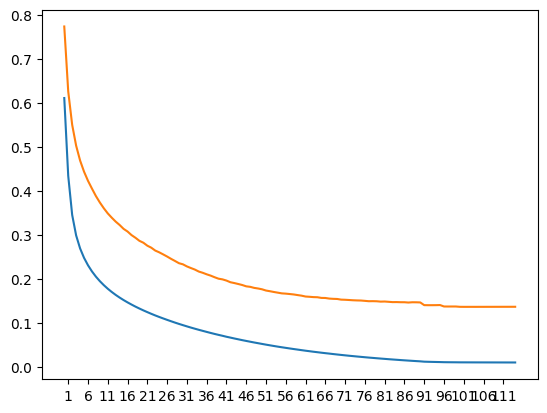


Training Medium with LR of 0.001...
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Medium with LR of 0.001 - F2: 0.835, Accuracy: 0.968, Precision: 0.726, Recall: 0.868


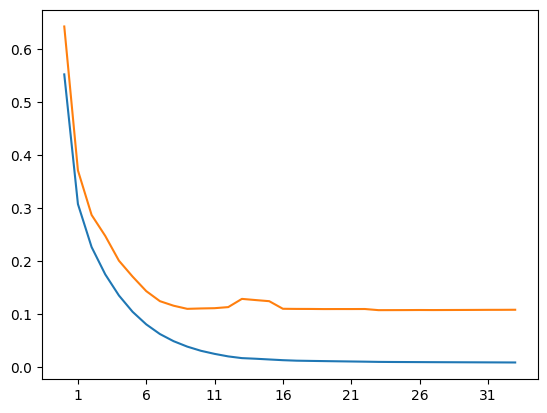


Training Deep with LR of 0.001...
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Deep with LR of 0.001 - F2: 0.816, Accuracy: 0.964, Precision: 0.697, Recall: 0.852


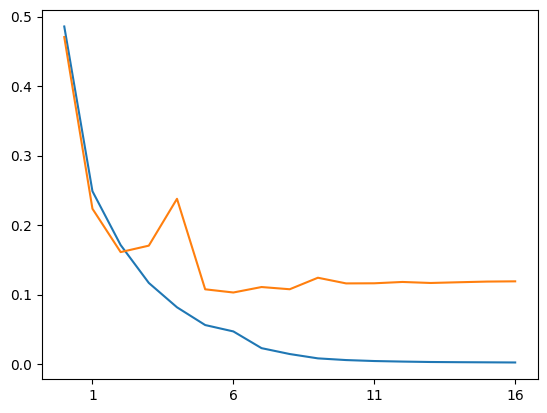


Training Deeper with LR of 0.001...
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Deeper with LR of 0.001 - F2: 0.821, Accuracy: 0.972, Precision: 0.778, Recall: 0.833


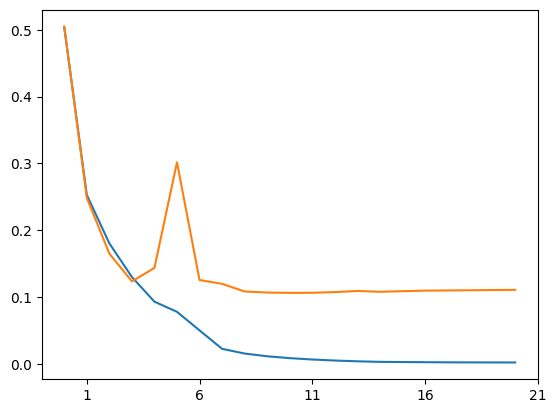


Training Wide with LR of 0.001...
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Wide with LR of 0.001 - F2: 0.830, Accuracy: 0.970, Precision: 0.750, Recall: 0.852


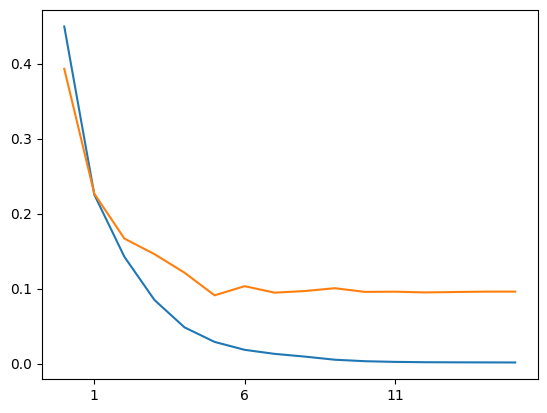


Training Wider with LR of 0.001...
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Wider with LR of 0.001 - F2: 0.830, Accuracy: 0.971, Precision: 0.765, Recall: 0.848


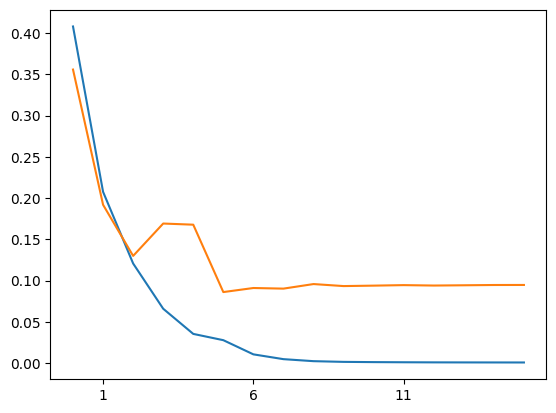


Training Deeper and Wider with LR of 0.001...
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Deeper and Wider with LR of 0.001 - F2: 0.787, Accuracy: 0.969, Precision: 0.775, Recall: 0.790


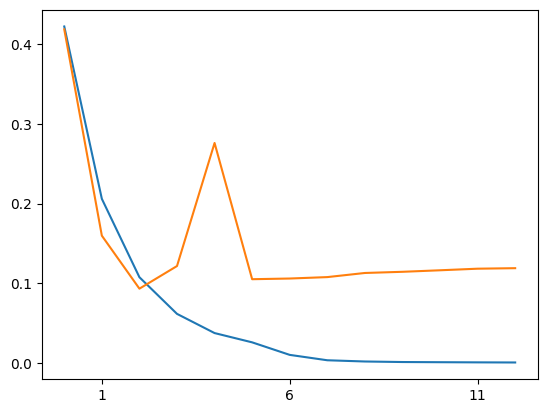

In [ ]:
# Train and evaluate each model architecture

for (layer_name, layer_sizes), learning_rate in product(architectures.items(), learning_rates):
    name = layer_name
    print(f"\nTraining {name}...")
    
    model = build_model(layer_sizes, X_train_processed.shape[1], learning_rate)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # patience is the number of epochs to tolerate
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=1/3, patience=3, min_lr=0.00003)
    model_history = model.fit(X_train_processed, y_train, validation_split=0.2, 
                        epochs=300, batch_size=128,                 # we need a big batch size as our dataset is imbalanced with minority class of 5%
                        class_weight=class_weights,                 # class_weights also address for the imbalance
                        callbacks=[early_stopping, reduce_lr],      # reduce_lr reduces the learning rate when the val_loss does not change signifiantly
                        verbose=0) 
    
    # Make predictions
    y_pred_proba = model.predict(X_test_processed).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Calculate classification metrics
    f2 = fbeta_score(y_test, y_pred, beta=2)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    results[name] = {"F2": f2, "Accuracy": accuracy, "Precision": precision, "Recall": recall}
    trained_models[name] = model  # store the trained model
    print(f"{name} - F2: {f2:.3f}, Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")

    histories[name] = model_history
    n_epoch_early = len(model_history.history['loss'])
    plt.xticks(range(1, n_epoch_early+1, 5))
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.show()


Model: Shallow with LR of 0.001
F2 Score:    0.804
Accuracy:    0.960
Precision:   0.674
Recall:      0.844

Model: Medium with LR of 0.001
F2 Score:    0.835
Accuracy:    0.968
Precision:   0.726
Recall:      0.868

Model: Deep with LR of 0.001
F2 Score:    0.816
Accuracy:    0.964
Precision:   0.697
Recall:      0.852

Model: Deeper with LR of 0.001
F2 Score:    0.821
Accuracy:    0.972
Precision:   0.778
Recall:      0.833

Model: Wide with LR of 0.001
F2 Score:    0.830
Accuracy:    0.970
Precision:   0.750
Recall:      0.852

Model: Wider with LR of 0.001
F2 Score:    0.830
Accuracy:    0.971
Precision:   0.765
Recall:      0.848

Model: Deeper and Wider with LR of 0.001
F2 Score:    0.787
Accuracy:    0.969
Precision:   0.775
Recall:      0.790
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report (Medium with LR of 0.001):
              precision    recall  f1-score   support

   Not Fraud       0.99      0.98      0.98      3410
       Fraud       0.73      0.87     

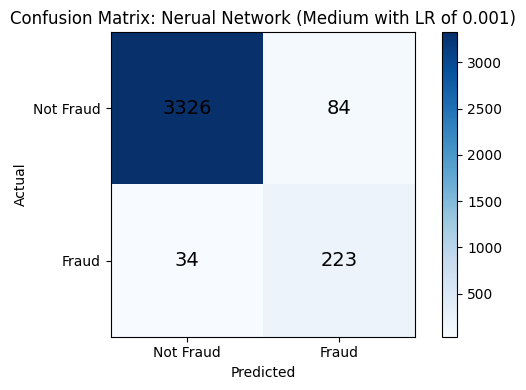

C:\Users\Jason\AppData\Local\Temp\ipykernel_24224\2748699562.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


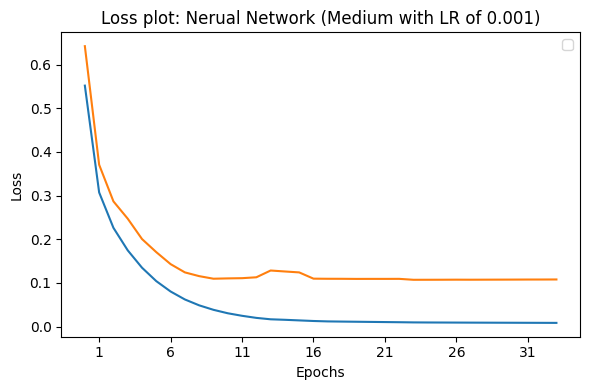

C:\Users\Jason\AppData\Local\Temp\ipykernel_24224\2748699562.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 600x400 with 0 Axes>

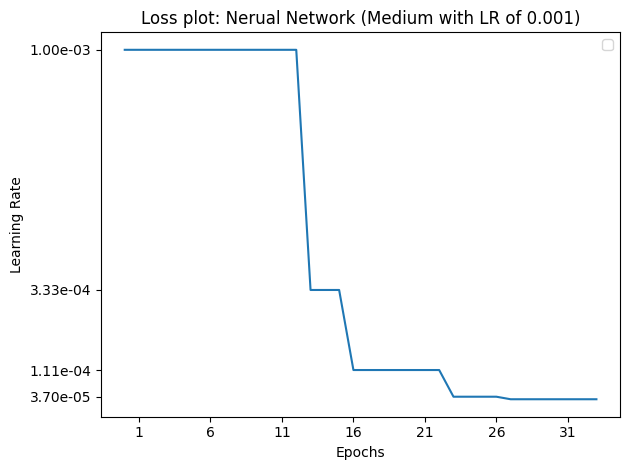

In [ ]:
###########################
##### Display results #####
###########################

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha='center', va='center', fontsize=14)
    plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
    plt.yticks([0, 1], ['Not Fraud', 'Fraud'])
    plt.tight_layout()
    plt.show()

def plot_loss(loss_history, title):
    plt.figure(figsize=(6, 4))
    plt.title(title)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks((range(1, len(loss_history['loss'])+1, 5)))
    
    plt.plot(loss_history['loss'])
    plt.plot(loss_history['val_loss'])
    plt.tight_layout()
    plt.show()

def plot_learning_rate(lr_history, title):
    plt.figure(figsize=(6, 4))
    fig, ax = plt.subplots()

    plt.title(title)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.xticks((range(1, len(lr_history)+1, 5)))
    plt.yticks([0.001 * (1/3)**i for i in range(4)])
    ax.set_yticklabels([f"{0.001 * (1/3)**i:.2e}" for i in range(4)])
    
    plt.plot(lr_history)
    plt.tight_layout()
    plt.show()

# Display results for each model
for name, metrics in results.items():
    print(f"\n{'='*50}")
    print(f"Model: {name}")
    print(f"{'='*50}")
    print(f"F2 Score:    {metrics['F2']:.3f}")
    print(f"Accuracy:    {metrics['Accuracy']:.3f}")
    print(f"Precision:   {metrics['Precision']:.3f}")
    print(f"Recall:      {metrics['Recall']:.3f}")

# Find best model by F2 score
best_model_name = max(results, key=lambda x: results[x]['F2'])
best_model = trained_models[best_model_name] 

# Predictions and confusion matrix
y_pred_proba = best_model.predict(X_test_processed).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

print(f"\nClassification Report ({best_model_name}):")
print(classification_report(y_test.astype(int), y_pred, target_names=['Not Fraud', 'Fraud']))

plot_confusion_matrix(confusion_matrix(y_test.astype(int), y_pred, labels=[0, 1]), 
                      f"Confusion Matrix: Nerual Network ({best_model_name})")
plot_loss(histories[best_model_name].history, f"Loss plot: Nerual Network ({best_model_name})")
plot_learning_rate(histories[best_model_name].history['learning_rate'], f"Loss plot: Nerual Network ({best_model_name})")

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


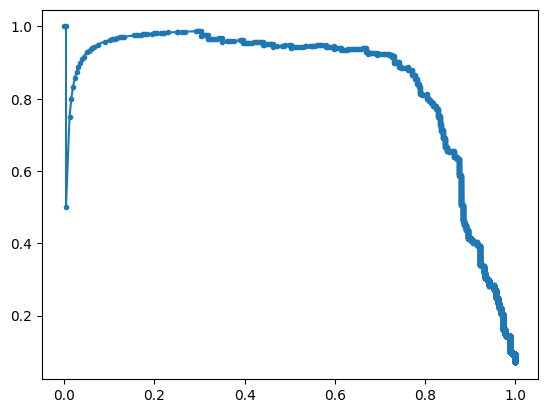

In [ ]:
from sklearn.metrics import precision_recall_curve
from numpy import argmax

model = trained_models['Medium with LR of 0.001']
model = trained_models['Shallow with LR of 0.001']
y_pred_proba = model.predict(X_test_processed).flatten()

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, marker='.', label='Logistic')
f2_scores = ((1+2**2) * precision * recall) / ((2**2 * precision) + recall)
f1_scores = ((1+1**2) * precision * recall) / ((1**2 * precision) + recall)

In [ ]:
max_i = argmax(f1_scores)
f1_scores[max_i], precision[max_i], recall[max_i], thresholds[max_i]

(np.float64(0.8215767634854771),
 np.float64(0.88),
 np.float64(0.7704280155642024),
 np.float32(0.95764434))

In [ ]:
max_i = argmax(f2_scores)
f2_scores[max_i], precision[max_i], recall[max_i], thresholds[max_i]

(np.float64(0.8167177914110431),
 np.float64(0.7717391304347826),
 np.float64(0.8287937743190662),
 np.float32(0.7863742))

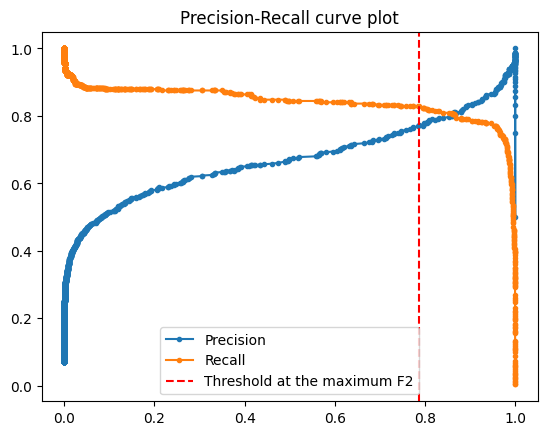

In [ ]:
plt.title('Precision-Recall curve plot')
plt.plot(thresholds, precision[:-1], marker='.', label='Precision')
plt.plot(thresholds, recall[:-1], marker='.', label='Recall')
plt.axvline(x=thresholds[max_i], color='red', linestyle='--', label='Threshold at the maximum F2')
plt.legend()

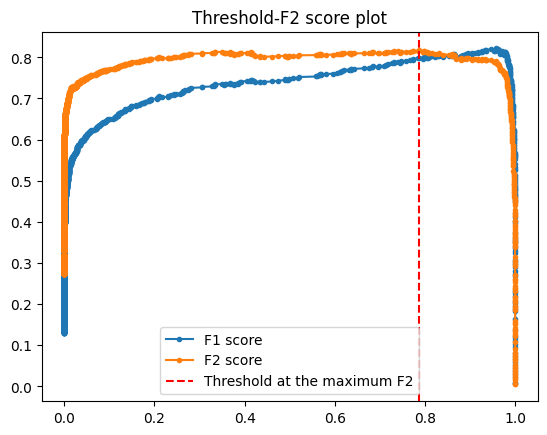

In [ ]:
plt.title('Threshold-F2 score plot')
# plt.plot(thresholds, marker='.', label='Threshold')
plt.plot(thresholds, f1_scores[:-1], marker='.', label='F1 score')
plt.plot(thresholds, f2_scores[:-1], marker='.', label='F2 score')
plt.axvline(x=thresholds[max_i], color='red', linestyle='--', label='Threshold at the maximum F2')
plt.legend()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
# precision_recall_fscore_support(y_test, (y_pred_proba > thresholds[max_i]).astype(int), beta=2, labels=['Not Fraud', 'Fraud'])
precision_recall_fscore_support(y_test, (y_pred_proba > thresholds[max_i]).astype(int), beta=2)

(array([0.98673349, 0.77090909]),
 array([0.98152493, 0.82490272]),
 array([0.98256224, 0.81350729]),
 array([3410,  257]))

In [ ]:
from _functions import custom_classification_report

print('Using threshold of 0.5')
print(custom_classification_report(y_test, (y_pred_proba > 0.5).astype(int), digits=3))

print(f'Using threshold of {thresholds[max_i]:.2f}') 
print(custom_classification_report(y_test, (y_pred_proba > thresholds[max_i]).astype(int), digits=3))

Using threshold of 0.5
           precision    recall  f2-score   support

Not Fraud      0.988     0.969     0.973      3410
    Fraud      0.674     0.844     0.804       257

 accuracy                          0.960      3667

Using threshold of 0.79
           precision    recall  f2-score   support

Not Fraud      0.987     0.982     0.983      3410
    Fraud      0.771     0.825     0.814       257

 accuracy                          0.971      3667



In [ ]:
tf.random.set_seed(42)

In [ ]:
############################
##### Define Functions #####
############################
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
########################
##### Load Dataset #####
########################

df = pd.read_csv("final_data.csv", index_col=0)
# df.head()
# df.isnull().sum()

In [ ]:
#############################################
##### Feature selection and engineering #####
#############################################

X_numeric_cols = ['telecommuting', 'has_company_logo', 'has_questions', 'location_has_non_latin',
                  'description_has_non_latin', 'requirements_has_non_latin', 'has_requirements',
                  'has_location', 'has_location_details']
X_text_cols = ['title', 'description_and_requirements']
y_col = ['fraudulent']

df2 = df[X_numeric_cols + X_text_cols + y_col].dropna()

df2["combined_text"] = df2["title"] + " " + df2["description_and_requirements"]

X_numeric = df2[X_numeric_cols]
X_text = df2["combined_text"]
y = df2[y_col].values.ravel()  # Convert to 1D array


In [ ]:
# Split the dataset
X_numeric_train, X_numeric_test, X_text_train, X_text_test, y_train, y_test = train_test_split(
    X_numeric, X_text, y, test_size=0.2, random_state=42
)

# Convert text to TF-IDF features so that the neural network can process them
tfidf = TfidfVectorizer(max_features=500, stop_words='english')
X_text_train_tfidf = tfidf.fit_transform(X_text_train)
X_text_test_tfidf = tfidf.transform(X_text_test)

# Combine numeric and text features
X_train_processed = np.hstack([X_numeric_train.values, X_text_train_tfidf.toarray()])
X_test_processed = np.hstack([X_numeric_test.values, X_text_test_tfidf.toarray()])

print(f"Training shape: {X_train_processed.shape}")
print(f"Test shape: {X_test_processed.shape}")


Training shape: (14667, 509)
Test shape: (3667, 509)


In [ ]:
def build_model(layer_sizes, input_dim, learning_rate):
    
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    
    for size in layer_sizes:
        model.add(layers.Dense(size, activation='relu'))
    
    model.add(layers.Dense(1, activation='sigmoid'))  # outputs log-likelihood
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights = [weights[0] / sqrt(2), weights[1] * sqrt(2)]
class_weights = dict(enumerate(weights))
class_weights

{0: np.float64(0.38117962215756734), 1: np.float64(9.756477102223043)}

In [ ]:
trained_models = {}

# different architectures to compare
architectures = {
    "Shallow": [32],
    "Medium": [64, 32],
    "Deep": [128, 64, 32],
    "Deeper": [128, 64, 32, 16],
    "Wide": [256, 128],
    "Wider": [512, 128],
    "Deeper and Wider":[512, 256, 128, 32]
}

learning_rates = [
    # 0.003,
    0.001,
    # 0.0003
]

# dictionary to store evaluation results and histories
results = {}
histories = {}

In [ ]:
X_train_processed = X_train_processed.astype(np.float32)
X_test_processed = X_test_processed.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)


Training Shallow with LR of 0.001...
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Shallow with LR of 0.001 - F2: 0.804, Accuracy: 0.960, Precision: 0.674, Recall: 0.844


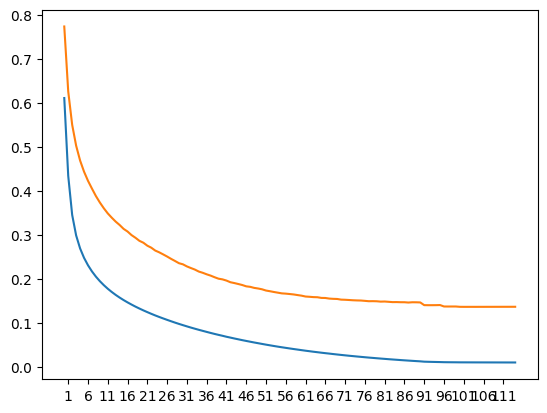


Training Medium with LR of 0.001...
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Medium with LR of 0.001 - F2: 0.835, Accuracy: 0.968, Precision: 0.726, Recall: 0.868


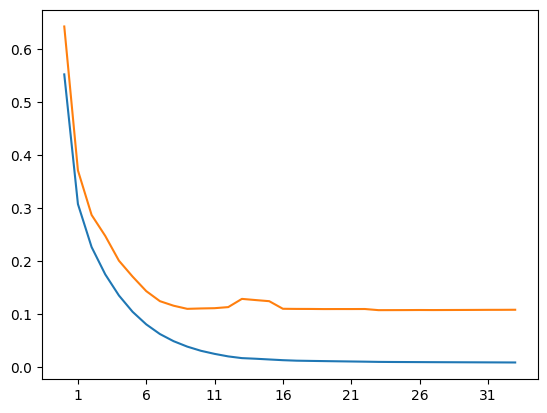


Training Deep with LR of 0.001...
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Deep with LR of 0.001 - F2: 0.816, Accuracy: 0.964, Precision: 0.697, Recall: 0.852


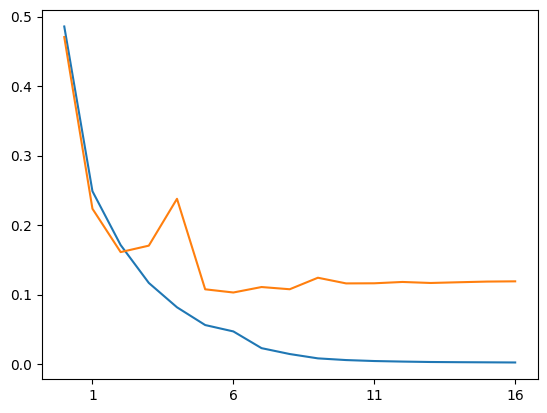


Training Deeper with LR of 0.001...
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Deeper with LR of 0.001 - F2: 0.821, Accuracy: 0.972, Precision: 0.778, Recall: 0.833


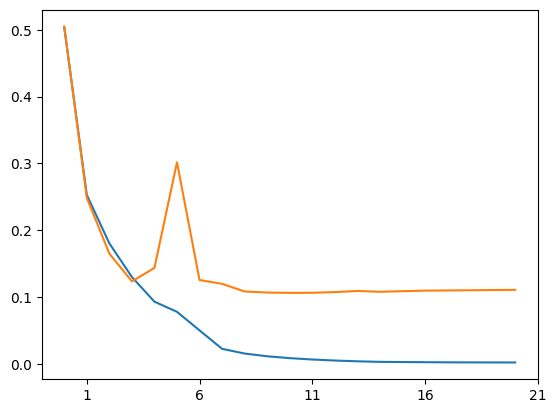


Training Wide with LR of 0.001...
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Wide with LR of 0.001 - F2: 0.830, Accuracy: 0.970, Precision: 0.750, Recall: 0.852


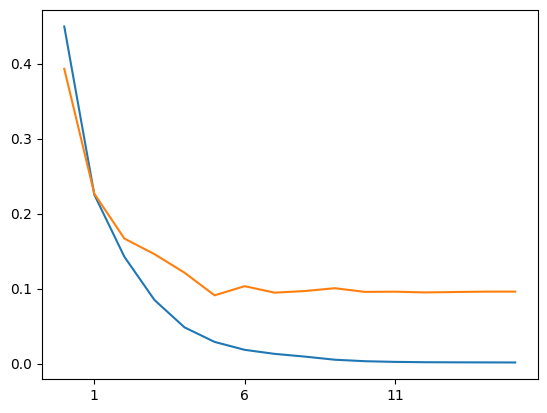


Training Wider with LR of 0.001...
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Wider with LR of 0.001 - F2: 0.830, Accuracy: 0.971, Precision: 0.765, Recall: 0.848


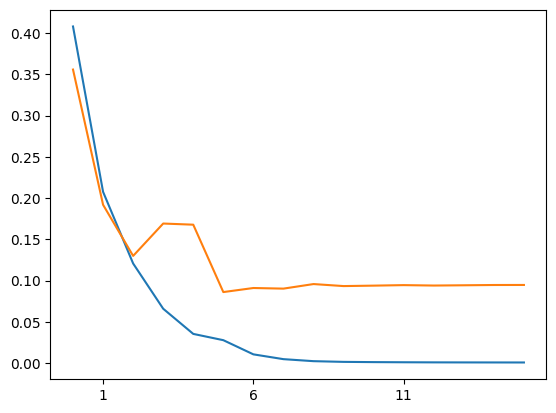


Training Deeper and Wider with LR of 0.001...
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Deeper and Wider with LR of 0.001 - F2: 0.787, Accuracy: 0.969, Precision: 0.775, Recall: 0.790


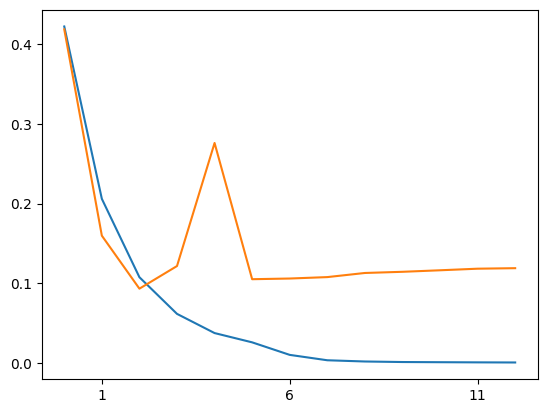

In [ ]:
# Train and evaluate each model architecture

for (layer_name, layer_sizes), learning_rate in product(architectures.items(), learning_rates):
    name = layer_name
    print(f"\nTraining {name}...")
    
    model = build_model(layer_sizes, X_train_processed.shape[1], learning_rate)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # patience is the number of epochs to tolerate
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=1/3, patience=3, min_lr=0.00003)
    model_history = model.fit(X_train_processed, y_train, validation_split=0.2, 
                        epochs=300, batch_size=128,                 # we need a big batch size as our dataset is imbalanced with minority class of 5%
                        class_weight=class_weights,                 # class_weights also address for the imbalance
                        callbacks=[early_stopping, reduce_lr],      # reduce_lr reduces the learning rate when the val_loss does not change signifiantly
                        verbose=0) 
    
    # Make predictions
    y_pred_proba = model.predict(X_test_processed).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Calculate classification metrics
    f2 = fbeta_score(y_test, y_pred, beta=2)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    results[name] = {"F2": f2, "Accuracy": accuracy, "Precision": precision, "Recall": recall}
    trained_models[name] = model  # store the trained model
    print(f"{name} - F2: {f2:.3f}, Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")

    histories[name] = model_history
    n_epoch_early = len(model_history.history['loss'])
    plt.xticks(range(1, n_epoch_early+1, 5))
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.show()


Model: Shallow with LR of 0.001
F2 Score:    0.804
Accuracy:    0.960
Precision:   0.674
Recall:      0.844

Model: Medium with LR of 0.001
F2 Score:    0.835
Accuracy:    0.968
Precision:   0.726
Recall:      0.868

Model: Deep with LR of 0.001
F2 Score:    0.816
Accuracy:    0.964
Precision:   0.697
Recall:      0.852

Model: Deeper with LR of 0.001
F2 Score:    0.821
Accuracy:    0.972
Precision:   0.778
Recall:      0.833

Model: Wide with LR of 0.001
F2 Score:    0.830
Accuracy:    0.970
Precision:   0.750
Recall:      0.852

Model: Wider with LR of 0.001
F2 Score:    0.830
Accuracy:    0.971
Precision:   0.765
Recall:      0.848

Model: Deeper and Wider with LR of 0.001
F2 Score:    0.787
Accuracy:    0.969
Precision:   0.775
Recall:      0.790
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report (Medium with LR of 0.001):
              precision    recall  f1-score   support

   Not Fraud       0.99      0.98      0.98      3410
       Fraud       0.73      0.87     

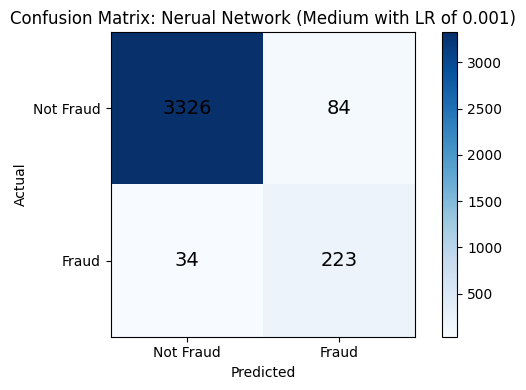

C:\Users\Jason\AppData\Local\Temp\ipykernel_24224\2748699562.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


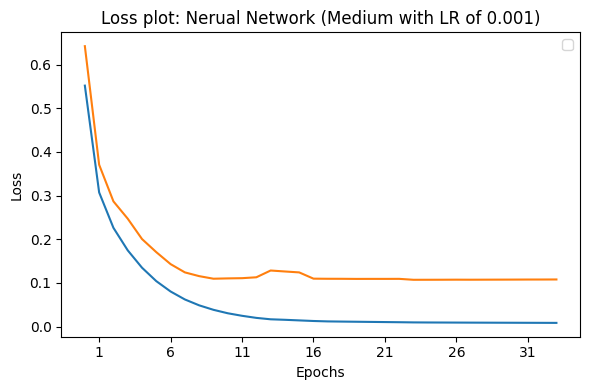

C:\Users\Jason\AppData\Local\Temp\ipykernel_24224\2748699562.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 600x400 with 0 Axes>

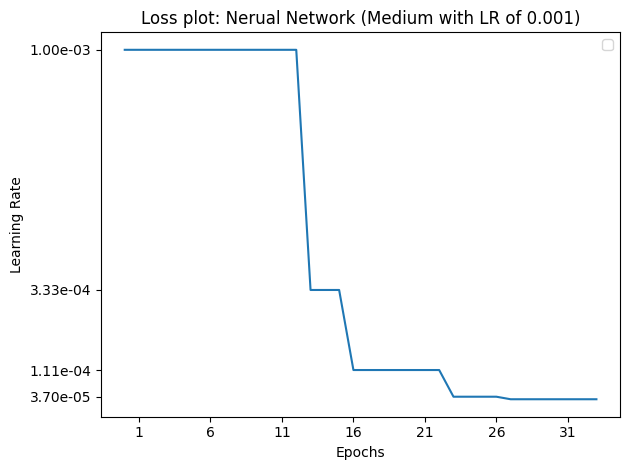

In [ ]:
###########################
##### Display results #####
###########################

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha='center', va='center', fontsize=14)
    plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
    plt.yticks([0, 1], ['Not Fraud', 'Fraud'])
    plt.tight_layout()
    plt.show()

def plot_loss(loss_history, title):
    plt.figure(figsize=(6, 4))
    plt.title(title)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks((range(1, len(loss_history['loss'])+1, 5)))
    
    plt.plot(loss_history['loss'])
    plt.plot(loss_history['val_loss'])
    plt.tight_layout()
    plt.show()

def plot_learning_rate(lr_history, title):
    plt.figure(figsize=(6, 4))
    fig, ax = plt.subplots()

    plt.title(title)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.xticks((range(1, len(lr_history)+1, 5)))
    plt.yticks([0.001 * (1/3)**i for i in range(4)])
    ax.set_yticklabels([f"{0.001 * (1/3)**i:.2e}" for i in range(4)])
    
    plt.plot(lr_history)
    plt.tight_layout()
    plt.show()

# Display results for each model
for name, metrics in results.items():
    print(f"\n{'='*50}")
    print(f"Model: {name}")
    print(f"{'='*50}")
    print(f"F2 Score:    {metrics['F2']:.3f}")
    print(f"Accuracy:    {metrics['Accuracy']:.3f}")
    print(f"Precision:   {metrics['Precision']:.3f}")
    print(f"Recall:      {metrics['Recall']:.3f}")

# Find best model by F2 score
best_model_name = max(results, key=lambda x: results[x]['F2'])
best_model = trained_models[best_model_name] 

# Predictions and confusion matrix
y_pred_proba = best_model.predict(X_test_processed).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

print(f"\nClassification Report ({best_model_name}):")
print(classification_report(y_test.astype(int), y_pred, target_names=['Not Fraud', 'Fraud']))

plot_confusion_matrix(confusion_matrix(y_test.astype(int), y_pred, labels=[0, 1]), 
                      f"Confusion Matrix: Nerual Network ({best_model_name})")
plot_loss(histories[best_model_name].history, f"Loss plot: Nerual Network ({best_model_name})")
plot_learning_rate(histories[best_model_name].history['learning_rate'], f"Loss plot: Nerual Network ({best_model_name})")

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


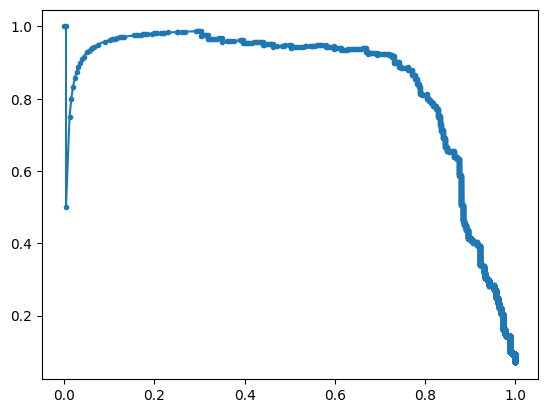

In [ ]:
from sklearn.metrics import precision_recall_curve
from numpy import argmax

model = trained_models['Medium with LR of 0.001']
model = trained_models['Shallow with LR of 0.001']
y_pred_proba = model.predict(X_test_processed).flatten()

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, marker='.', label='Logistic')
f2_scores = ((1+2**2) * precision * recall) / ((2**2 * precision) + recall)
f1_scores = ((1+1**2) * precision * recall) / ((1**2 * precision) + recall)

In [ ]:
max_i = argmax(f1_scores)
f1_scores[max_i], precision[max_i], recall[max_i], thresholds[max_i]

(np.float64(0.8215767634854771),
 np.float64(0.88),
 np.float64(0.7704280155642024),
 np.float32(0.95764434))

In [ ]:
max_i = argmax(f2_scores)
f2_scores[max_i], precision[max_i], recall[max_i], thresholds[max_i]

(np.float64(0.8167177914110431),
 np.float64(0.7717391304347826),
 np.float64(0.8287937743190662),
 np.float32(0.7863742))

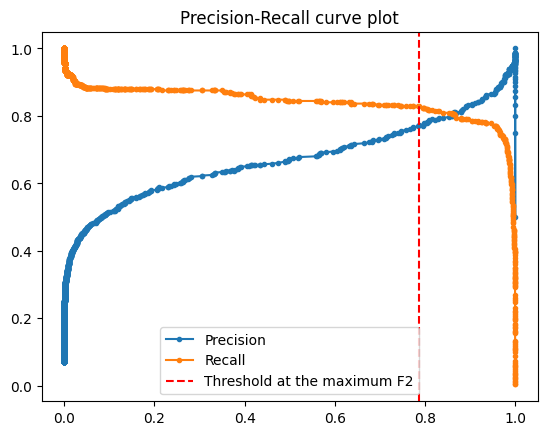

In [ ]:
plt.title('Precision-Recall curve plot')
plt.plot(thresholds, precision[:-1], marker='.', label='Precision')
plt.plot(thresholds, recall[:-1], marker='.', label='Recall')
plt.axvline(x=thresholds[max_i], color='red', linestyle='--', label='Threshold at the maximum F2')
plt.legend()

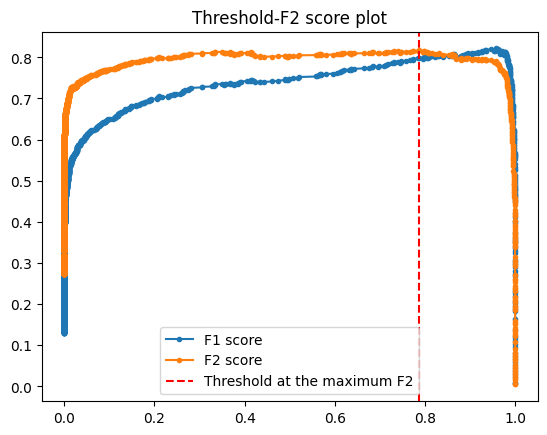

In [ ]:
plt.title('Threshold-F2 score plot')
# plt.plot(thresholds, marker='.', label='Threshold')
plt.plot(thresholds, f1_scores[:-1], marker='.', label='F1 score')
plt.plot(thresholds, f2_scores[:-1], marker='.', label='F2 score')
plt.axvline(x=thresholds[max_i], color='red', linestyle='--', label='Threshold at the maximum F2')
plt.legend()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
# precision_recall_fscore_support(y_test, (y_pred_proba > thresholds[max_i]).astype(int), beta=2, labels=['Not Fraud', 'Fraud'])
precision_recall_fscore_support(y_test, (y_pred_proba > thresholds[max_i]).astype(int), beta=2)

(array([0.98673349, 0.77090909]),
 array([0.98152493, 0.82490272]),
 array([0.98256224, 0.81350729]),
 array([3410,  257]))

In [ ]:
from _functions import custom_classification_report

print('Using threshold of 0.5')
print(custom_classification_report(y_test, (y_pred_proba > 0.5).astype(int), digits=3))

print(f'Using threshold of {thresholds[max_i]:.2f}') 
print(custom_classification_report(y_test, (y_pred_proba > thresholds[max_i]).astype(int), digits=3))

Using threshold of 0.5
           precision    recall  f2-score   support

Not Fraud      0.988     0.969     0.973      3410
    Fraud      0.674     0.844     0.804       257

 accuracy                          0.960      3667

Using threshold of 0.79
           precision    recall  f2-score   support

Not Fraud      0.987     0.982     0.983      3410
    Fraud      0.771     0.825     0.814       257

 accuracy                          0.971      3667



In [2]:
tf.random.set_seed(42)

In [3]:
############################
##### Define Functions #####
############################
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [4]:
########################
##### Load Dataset #####
########################

df = pd.read_csv("final_data.csv", index_col=0)
# df.head()
# df.isnull().sum()

In [5]:
#############################################
##### Feature selection and engineering #####
#############################################

X_numeric_cols = ['telecommuting', 'has_company_logo', 'has_questions', 'location_has_non_latin',
                  'description_has_non_latin', 'requirements_has_non_latin', 'has_requirements',
                  'has_location', 'has_location_details']
X_text_cols = ['title', 'description_and_requirements']
y_col = ['fraudulent']

df2 = df[X_numeric_cols + X_text_cols + y_col].dropna()

df2["combined_text"] = df2["title"] + " " + df2["description_and_requirements"]

X_numeric = df2[X_numeric_cols]
X_text = df2["combined_text"]
y = df2[y_col].values.ravel()  # Convert to 1D array


In [6]:
# Split the dataset
X_numeric_train, X_numeric_test, X_text_train, X_text_test, y_train, y_test = train_test_split(
    X_numeric, X_text, y, test_size=0.2, random_state=42
)

# Convert text to TF-IDF features so that the neural network can process them
tfidf = TfidfVectorizer(max_features=500, stop_words='english')
X_text_train_tfidf = tfidf.fit_transform(X_text_train)
X_text_test_tfidf = tfidf.transform(X_text_test)

# Combine numeric and text features
X_train_processed = np.hstack([X_numeric_train.values, X_text_train_tfidf.toarray()])
X_test_processed = np.hstack([X_numeric_test.values, X_text_test_tfidf.toarray()])

print(f"Training shape: {X_train_processed.shape}")
print(f"Test shape: {X_test_processed.shape}")


Training shape: (14667, 509)
Test shape: (3667, 509)


In [7]:
def build_model(layer_sizes, input_dim, learning_rate):
    
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    
    for size in layer_sizes:
        model.add(layers.Dense(size, activation='relu'))
    
    model.add(layers.Dense(1, activation='sigmoid'))  # outputs log-likelihood
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))
class_weights

{0: np.float64(0.5390693913554837), 1: np.float64(6.898871119473189)}

In [8]:
trained_models = {}

# different architectures to compare
architectures = {
    "Shallow": [32],
    "Medium": [64, 32],
    "Deep": [128, 64, 32],
    "Deeper": [128, 64, 32, 16],
    "Wide": [256, 128],
    "Wider": [512, 128],
    "Deeper and Wider":[512, 256, 128, 32]
}

learning_rates = [
    # 0.003,
    0.001,
    # 0.0003
]

# dictionary to store evaluation results and histories
results = {}
histories = {}

In [9]:
X_train_processed = X_train_processed.astype(np.float32)
X_test_processed = X_test_processed.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)


Training Shallow with LR of 0.001...
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Shallow with LR of 0.001 - F2: 0.812, Accuracy: 0.963, Precision: 0.692, Recall: 0.848


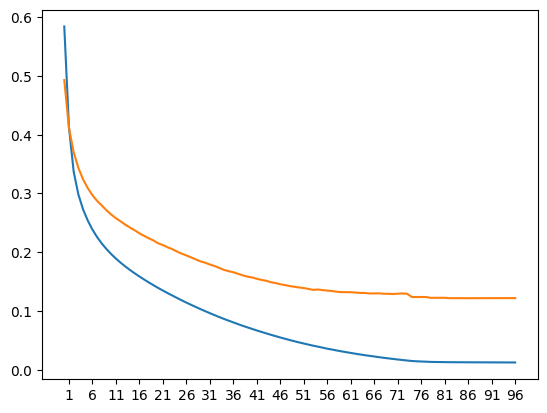


Training Medium with LR of 0.001...
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Medium with LR of 0.001 - F2: 0.826, Accuracy: 0.971, Precision: 0.771, Recall: 0.840


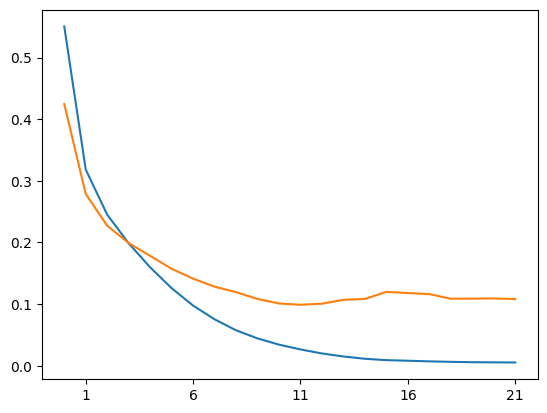


Training Deep with LR of 0.001...
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Deep with LR of 0.001 - F2: 0.819, Accuracy: 0.977, Precision: 0.860, Recall: 0.809


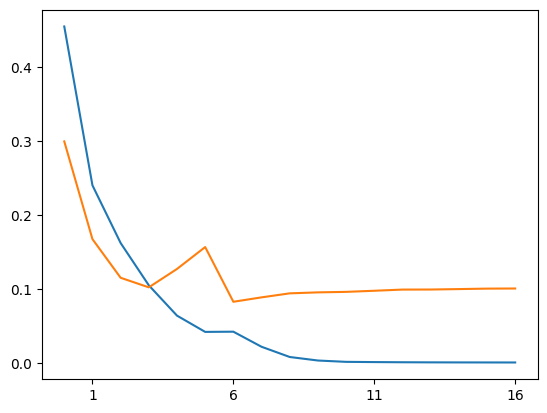


Training Deeper with LR of 0.001...
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Deeper with LR of 0.001 - F2: 0.820, Accuracy: 0.969, Precision: 0.747, Recall: 0.840


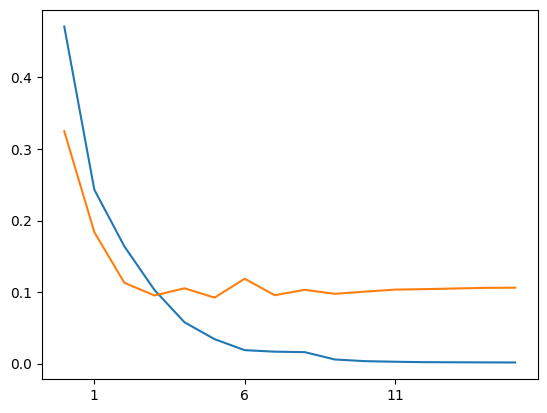


Training Wide with LR of 0.001...
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Wide with LR of 0.001 - F2: 0.837, Accuracy: 0.976, Precision: 0.821, Recall: 0.840


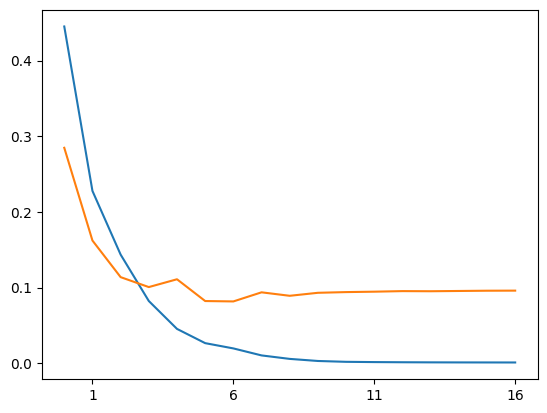


Training Wider with LR of 0.001...
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Wider with LR of 0.001 - F2: 0.827, Accuracy: 0.976, Precision: 0.835, Recall: 0.825


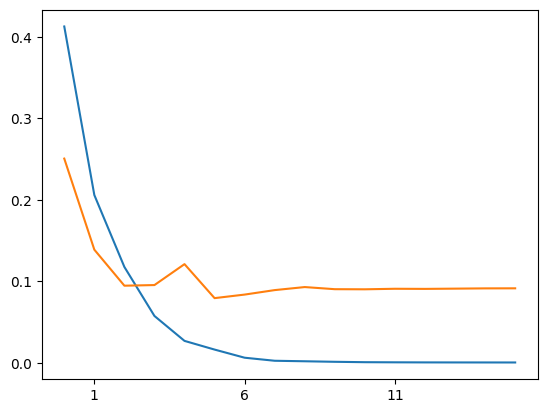


Training Deeper and Wider with LR of 0.001...
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Deeper and Wider with LR of 0.001 - F2: 0.830, Accuracy: 0.974, Precision: 0.805, Recall: 0.837


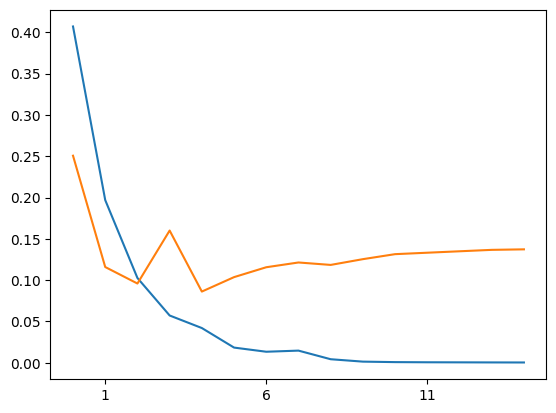

In [10]:
# Train and evaluate each model architecture

for (layer_name, layer_sizes), learning_rate in product(architectures.items(), learning_rates):
    name = layer_name + f' with LR of {learning_rate}'
    print(f"\nTraining {name}...")
    
    model = build_model(layer_sizes, X_train_processed.shape[1], learning_rate)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # patience is the number of epochs to tolerate
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=1/3, patience=3, min_lr=0.00003)
    model_history = model.fit(X_train_processed, y_train, validation_split=0.2, 
                        epochs=300, batch_size=128,                 # we need a big batch size as our dataset is imbalanced with minority class of 5%
                        class_weight=class_weights,                 # class_weights also address for the imbalance
                        callbacks=[early_stopping, reduce_lr],      # reduce_lr reduces the learning rate when the val_loss does not change signifiantly
                        verbose=0) 
    
    # Make predictions
    y_pred_proba = model.predict(X_test_processed).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Calculate classification metrics
    f2 = fbeta_score(y_test, y_pred, beta=2)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    results[name] = {"F2": f2, "Accuracy": accuracy, "Precision": precision, "Recall": recall}
    trained_models[name] = model  # store the trained model
    print(f"{name} - F2: {f2:.3f}, Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")

    histories[name] = model_history
    n_epoch_early = len(model_history.history['loss'])
    plt.xticks(range(1, n_epoch_early+1, 5))
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.show()


Model: Shallow with LR of 0.001
F2 Score:    0.812
Accuracy:    0.963
Precision:   0.692
Recall:      0.848

Model: Medium with LR of 0.001
F2 Score:    0.826
Accuracy:    0.971
Precision:   0.771
Recall:      0.840

Model: Deep with LR of 0.001
F2 Score:    0.819
Accuracy:    0.977
Precision:   0.860
Recall:      0.809

Model: Deeper with LR of 0.001
F2 Score:    0.820
Accuracy:    0.969
Precision:   0.747
Recall:      0.840

Model: Wide with LR of 0.001
F2 Score:    0.837
Accuracy:    0.976
Precision:   0.821
Recall:      0.840

Model: Wider with LR of 0.001
F2 Score:    0.827
Accuracy:    0.976
Precision:   0.835
Recall:      0.825

Model: Deeper and Wider with LR of 0.001
F2 Score:    0.830
Accuracy:    0.974
Precision:   0.805
Recall:      0.837
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Classification Report (Wide with LR of 0.001):
              precision    recall  f1-score   support

   Not Fraud       0.99      0.99      0.99      3410
       Fraud       0.82      0.84      0

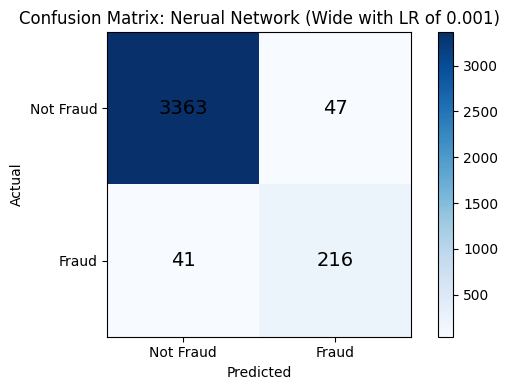

C:\Users\Jason\AppData\Local\Temp\ipykernel_40588\2748699562.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


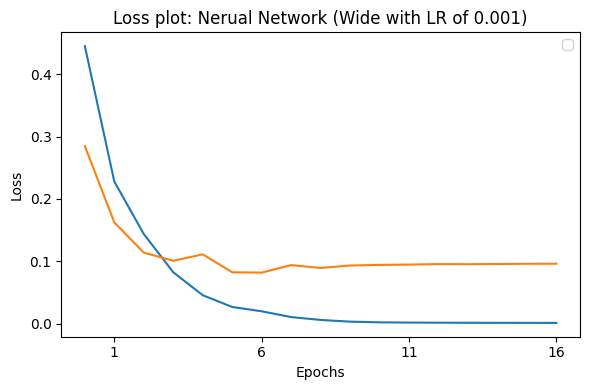

C:\Users\Jason\AppData\Local\Temp\ipykernel_40588\2748699562.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 600x400 with 0 Axes>

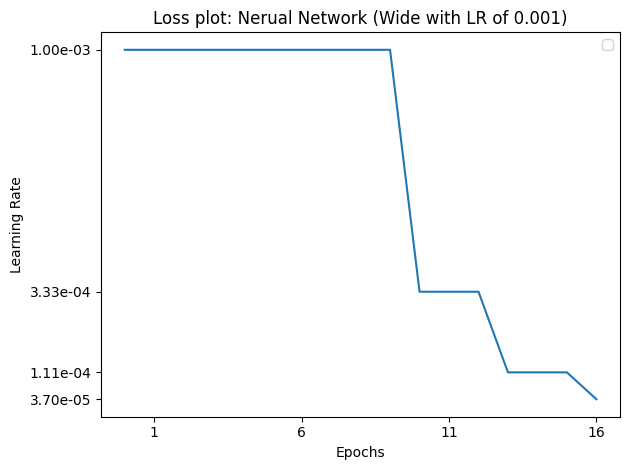

In [14]:
###########################
##### Display results #####
###########################

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha='center', va='center', fontsize=14)
    plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
    plt.yticks([0, 1], ['Not Fraud', 'Fraud'])
    plt.tight_layout()
    plt.show()

def plot_loss(loss_history, title):
    plt.figure(figsize=(6, 4))
    plt.title(title)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks((range(1, len(loss_history['loss'])+1, 5)))
    
    plt.plot(loss_history['loss'])
    plt.plot(loss_history['val_loss'])
    plt.tight_layout()
    plt.show()

def plot_learning_rate(lr_history, title):
    plt.figure(figsize=(6, 4))
    fig, ax = plt.subplots()

    plt.title(title)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.xticks((range(1, len(lr_history)+1, 5)))
    plt.yticks([0.001 * (1/3)**i for i in range(4)])
    ax.set_yticklabels([f"{0.001 * (1/3)**i:.2e}" for i in range(4)])
    
    plt.plot(lr_history)
    plt.tight_layout()
    plt.show()

# Display results for each model
for name, metrics in results.items():
    print(f"\n{'='*50}")
    print(f"Model: {name}")
    print(f"{'='*50}")
    print(f"F2 Score:    {metrics['F2']:.3f}")
    print(f"Accuracy:    {metrics['Accuracy']:.3f}")
    print(f"Precision:   {metrics['Precision']:.3f}")
    print(f"Recall:      {metrics['Recall']:.3f}")

# Find best model by F2 score
best_model_name = max(results, key=lambda x: results[x]['F2'])
best_model = trained_models[best_model_name] 

# Predictions and confusion matrix
y_pred_proba = best_model.predict(X_test_processed).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

print(f"\nClassification Report ({best_model_name}):")
print(classification_report(y_test.astype(int), y_pred, target_names=['Not Fraud', 'Fraud']))

plot_confusion_matrix(confusion_matrix(y_test.astype(int), y_pred, labels=[0, 1]), 
                      f"Confusion Matrix: Nerual Network ({best_model_name})")
plot_loss(histories[best_model_name].history, f"Loss plot: Nerual Network ({best_model_name})")
plot_learning_rate(histories[best_model_name].history['learning_rate'], f"Loss plot: Nerual Network ({best_model_name})")

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


'           precision    recall  f2-score   support\n\nNot Fraud       0.99      0.98      0.98      3410\n    Fraud       0.73      0.87      0.84       257\n\n accuracy                           0.97      3667\n'

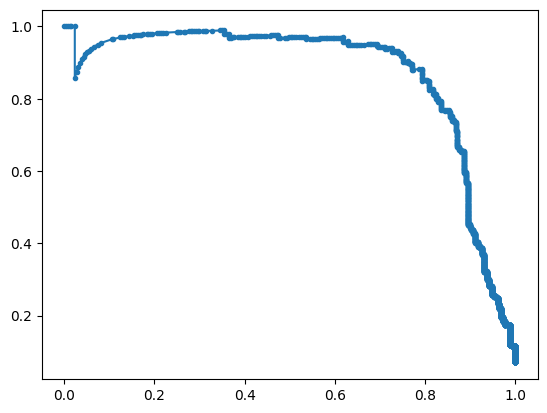

In [113]:
from sklearn.metrics import precision_recall_curve
from numpy import argmax

# model = trained_models['Shallow with LR of 0.001']
model = best_model
y_pred_proba = model.predict(X_test_processed).flatten()

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, marker='.', label='Logistic')
f2_scores = ((1+2**2) * precision * recall) / ((2**2 * precision) + recall)
f1_scores = ((1+1**2) * precision * recall) / ((1**2 * precision) + recall)


custom_classification_report(y_test, (y_pred_proba > 0.5))

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


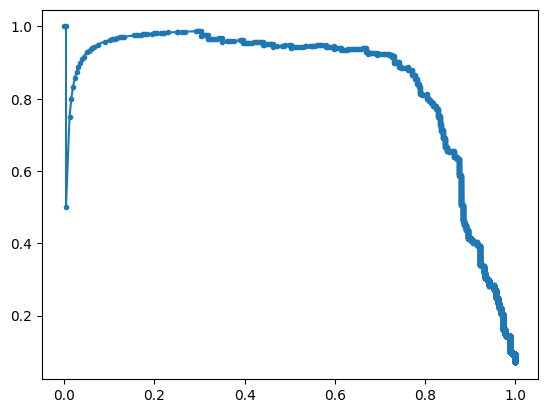

In [114]:
from sklearn.metrics import precision_recall_curve
from numpy import argmax

model = trained_models['Medium with LR of 0.001']
model = trained_models['Shallow with LR of 0.001']
y_pred_proba = model.predict(X_test_processed).flatten()

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, marker='.', label='Logistic')
f2_scores = ((1+2**2) * precision * recall) / ((2**2 * precision) + recall)
f1_scores = ((1+1**2) * precision * recall) / ((1**2 * precision) + recall)

In [115]:
max_f1_i = argmax(f1_scores)
f1_scores[max_f1_i], precision[max_f1_i], recall[max_f1_i], thresholds[max_f1_i]

(np.float64(0.8215767634854771),
 np.float64(0.88),
 np.float64(0.7704280155642024),
 np.float32(0.95764434))

In [116]:
max_f2_i = argmax(f2_scores)
f2_scores[max_f2_i], precision[max_f2_i], recall[max_f2_i], thresholds[max_f2_i]

(np.float64(0.8167177914110431),
 np.float64(0.7717391304347826),
 np.float64(0.8287937743190662),
 np.float32(0.7863742))

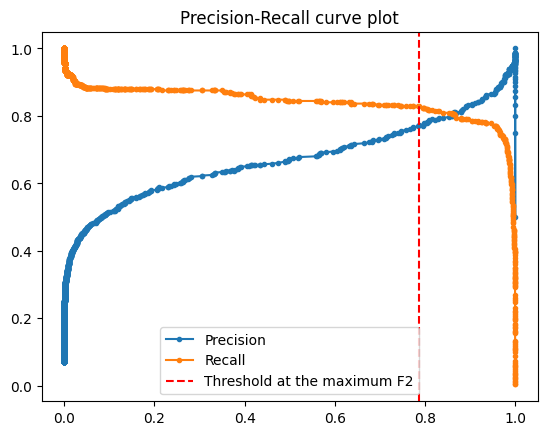

In [117]:
plt.title('Precision-Recall curve plot')
plt.plot(thresholds, precision[:-1], marker='.', label='Precision')
plt.plot(thresholds, recall[:-1], marker='.', label='Recall')
plt.axvline(x=thresholds[max_f2_i], color='red', linestyle='--', label='Threshold at the maximum F2')
plt.legend()

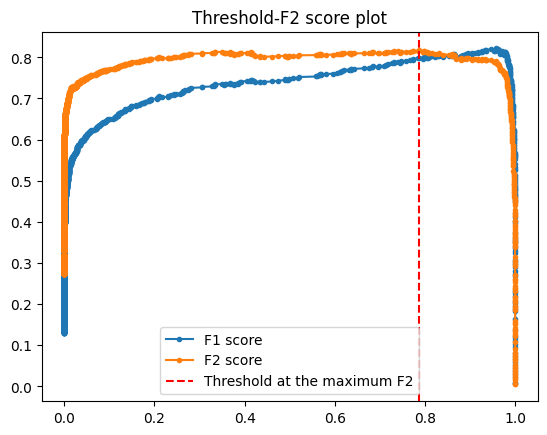

In [118]:
plt.title('Threshold-F2 score plot')
# plt.plot(thresholds, marker='.', label='Threshold')
plt.plot(thresholds, f1_scores[:-1], marker='.', label='F1 score')
plt.plot(thresholds, f2_scores[:-1], marker='.', label='F2 score')
plt.axvline(x=thresholds[max_f2_i], color='red', linestyle='--', label='Threshold at the maximum F2')
plt.legend()

### This is the correct values. Sanity check the output of the custom classification report below (the last one of the four)

In [121]:
from sklearn.metrics import precision_recall_fscore_support
# precision_recall_fscore_support(y_test, (y_pred_proba > thresholds[max_i]).astype(int), beta=2, labels=['Not Fraud', 'Fraud'])
precision_recall_fscore_support(y_test, (y_pred_proba > thresholds[max_f2_i]).astype(int), beta=2)

(array([0.98673349, 0.77090909]),
 array([0.98152493, 0.82490272]),
 array([0.98256224, 0.81350729]),
 array([3410,  257]))

In [122]:
from _functions import custom_classification_report

print('F1 score report: Using threshold of 0.5')
print(custom_classification_report(y_test, (y_pred_proba > 0.5).astype(int), beta=1, digits=3))

print(f'F1 score report: Using threshold of {thresholds[max_f1_i]:.2f}') 
print(custom_classification_report(y_test, (y_pred_proba > thresholds[max_f1_i]).astype(int), beta=1, digits=3))

print()
print('F2 score report: Using threshold of 0.5')
print(custom_classification_report(y_test, (y_pred_proba > 0.5).astype(int), beta=2, digits=3))

print(f'F2 score report: Using threshold of {thresholds[max_f2_i]:.2f}') 
print(custom_classification_report(y_test, (y_pred_proba > thresholds[max_f2_i]).astype(int), beta=2, digits=3))

F1 score report: Using threshold of 0.5
           precision    recall  f1-score   support

Not Fraud      0.988     0.969     0.979      3410
    Fraud      0.674     0.844     0.750       257

 accuracy                          0.960      3667

F1 score report: Using threshold of 0.96
           precision    recall  f1-score   support

Not Fraud      0.983     0.992     0.987      3410
    Fraud      0.879     0.767     0.819       257

 accuracy                          0.976      3667


F2 score report: Using threshold of 0.5
           precision    recall  f2-score   support

Not Fraud      0.988     0.969     0.973      3410
    Fraud      0.674     0.844     0.804       257

 accuracy                          0.960      3667

F2 score report: Using threshold of 0.79
           precision    recall  f2-score   support

Not Fraud      0.987     0.982     0.983      3410
    Fraud      0.771     0.825     0.814       257

 accuracy                          0.971      3667

